# Balance y Agenda de Investigación CIES 2021 - Pobreza, desigualdad 
## Authors: Javier Herrera, Norma Correa, Angelo Cozzubo
## Script by Jose Mendoza

## 0. Installing and loading pkgs

In [2]:
# !pip install -U deep_translator
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !pip install pyenchant
# !pip install gensim
# !pip install nltk
# !pip install xlrd
# !pip install openpyxl
# !pip install googletrans

In [3]:
# General libraries 
import os, re, spacy, sys, string 
#import enchant #spelling correction module 
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# Machine Learning tSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#NLTK 
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Gensim 
import gensim #For word2vec, etc
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

#Other 
import multiprocessing
from deep_translator import GoogleTranslator
from IPython.display import display
import random
from googletrans import Translator
from collections import defaultdict  # For word frequency
from time import time  # To time our operations

sys.path.insert(0, '../../../abstract_analysis/code')

[nltk_data] Downloading package omw-1.4 to C:\Users\cozzubo-
[nltk_data]     angelo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\cozzubo-
[nltk_data]     angelo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\cozzubo-
[nltk_data]     angelo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
random.seed(123)

## 1. Pre-processing
### Translation, lower case, remove punctuation, remove stopwords, stemming, lematization

In [5]:
# Load 
data = pd.read_excel(r"C:\Users\cozzubo-angelo\Downloads\CIES_BALANCE\220505 Base de Publicaciones.xlsx")
data['input'] = data['Title']+data['Abstract']
data['input'] = data['input'].str.split('©',1)
data['input'] = data['input'].str[0]

In [6]:
# Translation
translations = {}

#Drop duplicates items (only 2 items)
data = data.drop_duplicates(subset=['input'])

#unique_elements = data['input'].unique()
unique_elements = data[['input','Tema']]

for element in unique_elements['input']:
    # El translator tiene una extensión máxima
    try:
        translations[element] = GoogleTranslator(source='auto', target='en').translate(element)
    except:
        translations[element] = element

#unique_elements_tr = pd.DataFrame.from_dict(translations.items())
unique_elements_tr = pd.DataFrame.from_dict(translations.items())

In [7]:
# Concat dataframes
data_m = pd.concat([data, unique_elements_tr], axis=1)

In [8]:
# Lower case text
data_m= data_m.applymap(lambda s:s.lower() if type(s) == str else s)

In [9]:
# Remove punctuation
punct = set(string.punctuation) 

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = str(text).replace(punctuation, '')
    return text

data_m[2] = data_m[1].apply(remove_punctuations)

In [10]:
# Remove stopwords
stop = stopwords.words('english')

stop.extend(['among', 'however', 'le', 'edu', 'use','according','ass'])

pat = r'\b(?:{})\b'.format('|'.join(stop))

data_m[3] = data_m[2].str.replace(pat, '')

C:\Users\COZZUB~1\AppData\Local\Temp/ipykernel_15108/3016213047.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data_m[3] = data_m[2].str.replace(pat, '')


In [11]:
# Stemming -> reducing inflected words to their word stem, base or root form
stemmer = PorterStemmer()

data_m[4] = data_m[3].str.split()

data_m[4] = data_m[4].apply(lambda x: [stemmer.stem(y) for y in x])

In [12]:
# Lemmatization -> grouping together the inflected forms of a qord so they can by analyzed as a single item 
lemmatizer = WordNetLemmatizer()

data_m[5] = data_m[3].str.split()

data_m[5] = data_m[5].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [13]:
data_m = data_m.rename(columns={0:'inicial', 
                                1:'lowercase', 
                                2:'punctuation', 
                                3:'stopwords', 
                                4:'stemmed', 
                                5:'lemmatized'})

data_m.dropna(subset = ['Abstract'], inplace = True)

In [14]:
# Drop NA and missings 
data_m.replace('[nan]', "NaN", inplace=True)
data_m.dropna(subset = ['Abstract'], inplace = True)

In [15]:
#Phraser
sent = [row for row in data_m['lemmatized']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [16]:
# Show 3 first rows as example and column names 
data.head(2)

,Title,Grupo,Tipo de Publicación,Authors,Abstract,Tema,Tipo de Tesis,language,input
0,acceso a la salud e incidencia de enfermedades,2,Análisis y propuesta de financiamiento para el Seguro Integral de Salud,"Ysurraga, Faustino Miguel Sánchez","El objetivo de la presente investigación es diseñar una propuesta de financiamiento para el Seguro Integral de Salud (SIS) en el marco del aseguramiento universal en salud (AUS), para lo cual se considera el análisis de las causas del crecimiento de la población asegurada en el SIS, explicando, además, las dificultades y limitaciones que actualmente tiene la institución para financiar la prestación de los servicios de salud. Con la promulgación de la Ley N°29344 se establece un nuevo modelo de cobertura en salud para la población del país sobre la base de un plan mínimo de beneficios denominado Plan Esencial de Aseguramiento en Salud (PEAS) (Congreso de la República 2009). La implantación del aseguramiento universal en salud garantiza que todas las personas tengan acceso a los servicios de salud de calidad y en forma oportuna, priorizando a la población de menores recursos. Esta Ley establece que el SIS financia en forma exclusiva el régimen subsidiado (gratuito). En el año 2017 el SIS registró una población afiliada de 16,5 millones de personas, que representa el 52% de la población del país; habiéndose asignado en ese mismo año un presupuesto de S/ 1.410 millones de soles para financiar 74,1 millones de atenciones de salud. El rápido crecimiento de los asegurados en el SIS en los últimos años ha causado dificultades en la atención de los servicios en los establecimientos de salud, ocasionando -sobre todo en los hospitales- el colapso de los servicios por la creciente demanda de los afiliados del SIS, generando malestar en la población asegurada. El presente trabajo se ha desarrollado dentro del alcance de la investigación descriptiva y explicativa sobre las características del aseguramiento universal en salud y su financiamiento. El diseño de investigación considera la investigación no experimental, ya que en el presente trabajo no se manipulan las variables observadas. También considera el estudio transversal y longitudinal, ya que se toman los datos en un tiempo determinado y en varios periodos para analizar los cambios que ocurren en el tiempo. Este trabajo se basa en información secundaria y estudios de fuentes especializadas en el aseguramiento universal en salud",thesis,Tesis de Maestría,1.0,"acceso a la salud e incidencia de enfermedadesEl objetivo de la presente investigación es diseñar una propuesta de financiamiento para el Seguro Integral de Salud (SIS) en el marco del aseguramiento universal en salud (AUS), para lo cual se considera el análisis de las causas del crecimiento de la población asegurada en el SIS, explicando, además, las dificultades y limitaciones que actualmente tiene la institución para financiar la prestación de los servicios de salud. Con la promulgación de la Ley N°29344 se establece un nuevo modelo de cobertura en salud para la población del país sobre la base de un plan mínimo de beneficios denominado Plan Esencial de Aseguramiento en Salud (PEAS) (Congreso de la República 2009). La implantación del aseguramiento universal en salud garantiza que todas las personas tengan acceso a los servicios de salud de calidad y en forma oportuna, priorizando a la población de menores recursos. Esta Ley establece que el SIS financia en forma exclusiva el régimen subsidiado (gratuito). En el año 2017 el SIS registró una población afiliada de 16,5 millones de personas, que representa el 52% de la población del país; habiéndose asignado en ese mismo año un presupuesto de S/ 1.410 millones de soles para financiar 74,1 millones de atenciones de salud. El rápido crecimiento de los asegurados en el SIS en los últimos años ha causado dificultades en la atención de los servicios en los establecimientos de salud, ocasionando -sobre todo en los hospitales- el colapso de los ser

In [17]:
print("DB has the following columns:", list(data.columns))
print("DB has the following number of references:", (data.shape[0]))

DB has the following columns: ['Title', 'Grupo', 'Tipo de Publicación', 'Authors', 'Abstract', 'Tema', 'Tipo de Tesis', 'language', 'input']
DB has the following number of references: 584


## 1. Analysis: Full corpus 

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [19]:
w2v_model = Word2Vec(min_count=30,
                     window=10,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1,
                     seed= 1)

In [20]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [21]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.09 mins


### 1.1 Similar words to most frequent ones

In [22]:
# Word frequencies 
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['poverty',
 'peru',
 'health',
 'study',
 'child',
 'social',
 'result',
 'household',
 'country',
 'level']

In [23]:
common_words = sorted(word_freq, key=word_freq.get, reverse=True)[:7]
common_words

['poverty', 'peru', 'health', 'study', 'child', 'social', 'result']

In [24]:
for commonword in common_words:
    print("\n", ("*"*10), commonword.upper(), ("*"*10), "\n")
    print(w2v_model.wv.most_similar(positive=[commonword]))


 ********** POVERTY ********** 

[('gdp', 0.9887486696243286), ('region', 0.9860445261001587), ('economic_growth', 0.9858312010765076), ('reduction', 0.9841269254684448), ('investment', 0.9840555191040039), ('mining', 0.9818304777145386), ('sector', 0.9794144630432129), ('policy', 0.9756600856781006), ('process', 0.9738988280296326), ('spending', 0.9729577302932739)]

 ********** PERU ********** 

[('measure', 0.9989991784095764), ('relationship', 0.9986849427223206), ('measured', 0.9986000061035156), ('decrease', 0.9985547065734863), ('across', 0.9983113408088684), ('relative', 0.9983054399490356), ('overall', 0.9981785416603088), ('ass', 0.9980828762054443), ('estimate', 0.9980185627937317), ('difference', 0.9979443550109863)]

 ********** HEALTH ********** 

[('conclusion', 0.9942246675491333), ('treatment', 0.9921879768371582), ('sociodemographic', 0.9916867017745972), ('interval', 0.991169810295105), ('anemia', 0.9906576871871948), ('symptom', 0.9901719689369202), ('adult', 0.990

### 1.2 Word tSNE 

In [25]:
numWords = 100
targetWords = w2v_model.wv.index_to_key[:numWords]

In [26]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2v_model.wv[word])

wordsSubMatrix = np.array(wordsSubMatrix)

In [27]:
#T-SNE 
tsneWords = TSNE(n_components = 3, random_state=1).fit_transform(wordsSubMatrix)

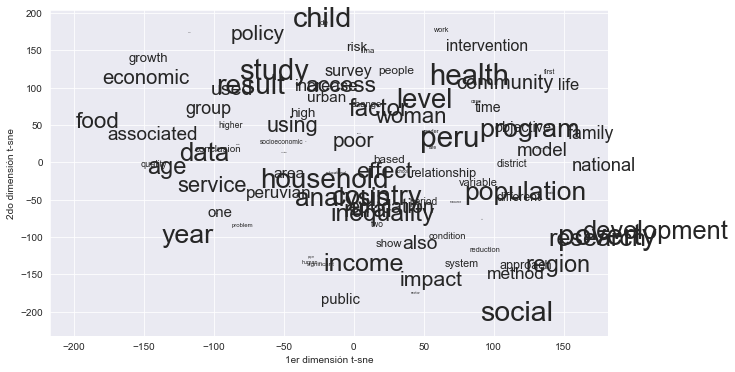

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(True)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  30 * (numWords - i) / numWords)
#plt.xticks(())
#plt.yticks(())
plt.xlabel("1er dimensión t-sne")
plt.ylabel("2do dimensión t-sne")
#plt.savefig('/Users/joseantoniomendozasanchez/abstract_analysis/tsne_general.png')
plt.show()

## 2.Analysis: Poverty corpus 

In [29]:
data_1 = data_m[data_m['Grupo'] == 1]
len(data_1)

184

In [30]:
#phraser
sent = [row for row in data_1['lemmatized']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
len(sentences)

184

In [31]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [32]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.02 mins


### 2.1 Similar words to most frequent ones

In [33]:
# Word frequencies 
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['poverty',
 'peru',
 'result',
 'country',
 'social',
 'level',
 'study',
 'inequality',
 'research',
 'region']

In [34]:
common_words = sorted(word_freq, key=word_freq.get, reverse=True)[:7]
common_words

['poverty', 'peru', 'result', 'country', 'social', 'level', 'study']

In [35]:
for commonword in common_words:
    print("\n", ("*"*10), commonword.upper(), ("*"*10), "\n")
    print(w2v_model.wv.most_similar(positive=[commonword]))


 ********** POVERTY ********** 

[('impact', 0.996833860874176), ('analysis', 0.9966070652008057), ('public', 0.995897650718689), ('labor', 0.9956215023994446), ('human', 0.9954096078872681), ('life', 0.9953705668449402), ('investment', 0.995307445526123), ('population', 0.9952043890953064), ('process', 0.9951886534690857), ('department', 0.9950262308120728)]

 ********** PERU ********** 

[('gdp', 0.9972993731498718), ('model', 0.9970418214797974), ('relationship', 0.996110737323761), ('inequality', 0.9947454333305359), ('one', 0.9943032264709473), ('national', 0.994191586971283), ('method', 0.9941644668579102), ('indicator', 0.9931303262710571), ('condition', 0.9929400682449341), ('increase', 0.9918418526649475)]

 ********** RESULT ********** 

[('study', 0.9818747043609619), ('state', 0.9764513969421387), ('food', 0.975650429725647), ('since', 0.9751879572868347), ('community', 0.9750234484672546), ('peruvian', 0.9738785624504089), ('one', 0.971354067325592), ('woman', 0.971327722

### 2.2 Word tSNE 

In [36]:
numWords = 30
targetWords = w2v_model.wv.index_to_key[:numWords]
targetWords

['poverty',
 'peru',
 'result',
 'country',
 'social',
 'level',
 'study',
 'inequality',
 'research',
 'region',
 'data',
 'household',
 'growth',
 'income',
 'analysis',
 'population',
 'public',
 'child',
 'poor',
 'economic',
 'period',
 'model',
 'reduction',
 'policy',
 'used',
 'year',
 'using',
 'health',
 'family',
 'food']

In [37]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2v_model.wv[word])

wordsSubMatrix = np.array(wordsSubMatrix)

In [38]:
#T-SNE 
tsneWords = TSNE(n_components = 3, random_state=1).fit_transform(wordsSubMatrix)

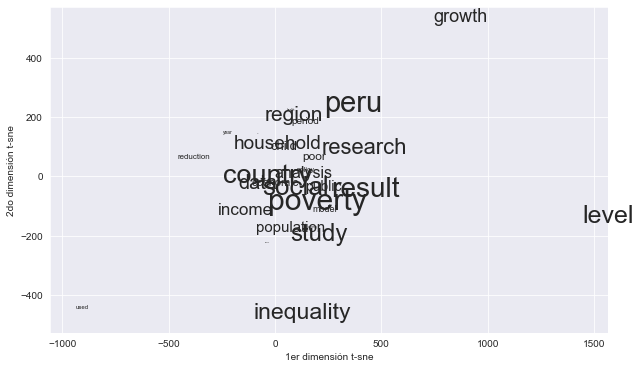

In [39]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(True)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  30 * (numWords - i) / numWords)
#plt.xticks(())
#plt.yticks(())
plt.xlabel("1er dimensión t-sne")
plt.ylabel("2do dimensión t-sne")
#plt.savefig('/Users/joseantoniomendozasanchez/abstract_analysis/tsne_general.png')
plt.show()

## 3. Analysis: Inequality corpus 

In [40]:
data_2 = data_m[data_m['Grupo'] == 2]
len(data_2)

194

In [41]:
#phraser
sent = [row for row in data_2['lemmatized']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
len(sentences)

194

In [43]:
w2v_model = Word2Vec(min_count=30,
                     window=10,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1,
                     seed= 1)

In [44]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [45]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


### 3.1 Similar words to most frequent ones

In [46]:
# Word frequencies 
from collections import defaultdict  # For word frequency

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['health',
 'poverty',
 'program',
 'child',
 'peru',
 'social',
 'rural',
 'study',
 'household',
 'country']

In [47]:
common_words = sorted(word_freq, key=word_freq.get, reverse=True)[:7]
common_words

['health', 'poverty', 'program', 'child', 'peru', 'social', 'rural']

In [48]:
for commonword in common_words:
    print("\n", ("*"*10), commonword.upper(), ("*"*10), "\n")
    print(w2v_model.wv.most_similar(positive=[commonword]))


 ********** HEALTH ********** 

[('care', 0.9994407296180725), ('analysis', 0.9994020462036133), ('study', 0.9993995428085327), ('main', 0.9993818402290344), ('access', 0.999366819858551), ('latin', 0.9993563294410706), ('national', 0.9993403553962708), ('objective', 0.9993398189544678), ('peruvian', 0.9993374347686768), ('one', 0.9993294477462769)]

 ********** POVERTY ********** 

[('urban', 0.9994189143180847), ('extreme', 0.9994171857833862), ('paper', 0.9994142055511475), ('transfer', 0.9994104504585266), ('poor', 0.999402642250061), ('factor', 0.9994008541107178), ('national', 0.9993876814842224), ('carried', 0.9993864297866821), ('significant', 0.9993860125541687), ('present', 0.9993752837181091)]

 ********** PROGRAM ********** 

[('support', 0.9994714260101318), ('social_program', 0.9994471073150635), ('social', 0.9994210600852966), ('case', 0.9994078278541565), ('carried', 0.9994056224822998), ('life', 0.9993985295295715), ('year', 0.9993841052055359), ('family', 0.999383091

### 3.2 Word tSNE 

In [49]:
numWords = 30
targetWords = w2v_model.wv.index_to_key[:numWords]
targetWords

['health',
 'poverty',
 'program',
 'child',
 'social',
 'peru',
 'rural',
 'study',
 'household',
 'country',
 'result',
 'year',
 'woman',
 'service',
 'development',
 'research',
 'area',
 'level',
 'population',
 'education',
 'analysis',
 'access',
 'factor',
 'policy',
 'age',
 'intervention',
 'family',
 'national',
 'school',
 'gender']

In [50]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2v_model.wv[word])

wordsSubMatrix = np.array(wordsSubMatrix)

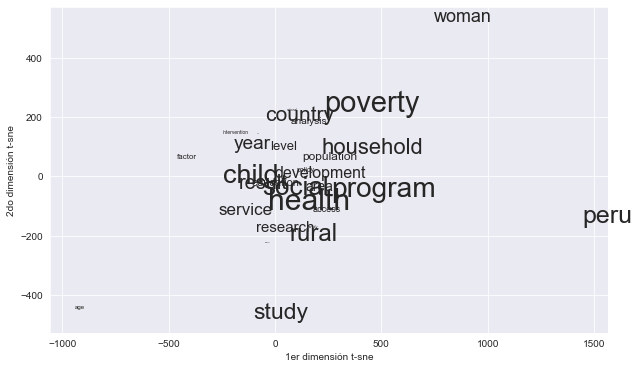

In [51]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(True)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  30 * (numWords - i) / numWords)
#plt.xticks(())
#plt.yticks(())
plt.xlabel("1er dimensión t-sne")
plt.ylabel("2do dimensión t-sne")
#plt.savefig('/Users/joseantoniomendozasanchez/abstract_analysis/tsne_general.png')
plt.show()

## 4. Analysis: Other topics corpus 

In [52]:
data_3 = data_m[data_m['Grupo'] == 3]
len(data_3)

205

In [57]:
#phraser
sent = [row for row in data_3['lemmatized']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]
len(sentences)

205

In [58]:
w2v_model = Word2Vec(min_count=30,
                     window=10,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1,
                     seed= 1)

In [59]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [60]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.02 mins


### 4.1 Similar words to most frequent ones

In [61]:
# Word frequencies 
from collections import defaultdict  # For word frequency

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['health',
 'peru',
 'study',
 'child',
 'country',
 'social',
 'year',
 'result',
 'household',
 'age']

In [63]:
common_words = sorted(word_freq, key=word_freq.get, reverse=True)[:7]
common_words

['health', 'peru', 'study', 'child', 'country', 'social', 'year']

In [64]:
for commonword in common_words:
    print("\n", ("*"*10), commonword.upper(), ("*"*10), "\n")
    print(w2v_model.wv.most_similar(positive=[commonword]))


 ********** HEALTH ********** 

[('age', 0.9994738698005676), ('using', 0.9994625449180603), ('problem', 0.9994527101516724), ('status', 0.9994266033172607), ('quality', 0.999426007270813), ('prevalence', 0.9994186758995056), ('four', 0.9994014501571655), ('index', 0.9993972182273865), ('two', 0.999396562576294), ('living', 0.9993701577186584)]

 ********** PERU ********** 

[('factor', 0.9995062947273254), ('objective', 0.9995022416114807), ('living', 0.9994863271713257), ('two', 0.9994567036628723), ('capital', 0.9994527101516724), ('important', 0.9994390606880188), ('show', 0.9994359612464905), ('growth', 0.999434769153595), ('urban', 0.9994332194328308), ('population', 0.9994207620620728)]

 ********** STUDY ********** 

[('woman', 0.9995161294937134), ('objective', 0.9995074272155762), ('outcome', 0.9994481801986694), ('life', 0.999447762966156), ('high', 0.9994385838508606), ('main', 0.9994165897369385), ('control', 0.9994062185287476), ('human', 0.9994024634361267), ('economic'

### 4.2 Similar words to most frequent ones

In [65]:
numWords = 30
targetWords = w2v_model.wv.index_to_key[:numWords]
targetWords

['health',
 'peru',
 'study',
 'child',
 'country',
 'social',
 'year',
 'result',
 'household',
 'age',
 'data',
 'income',
 'community',
 'associated',
 'access',
 'effect',
 'poverty',
 'population',
 'higher',
 'level',
 'food',
 'analysis',
 'factor',
 'development',
 'education',
 'policy',
 'region',
 'inequality',
 'using',
 'water']

In [66]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(w2v_model.wv[word])

wordsSubMatrix = np.array(wordsSubMatrix)

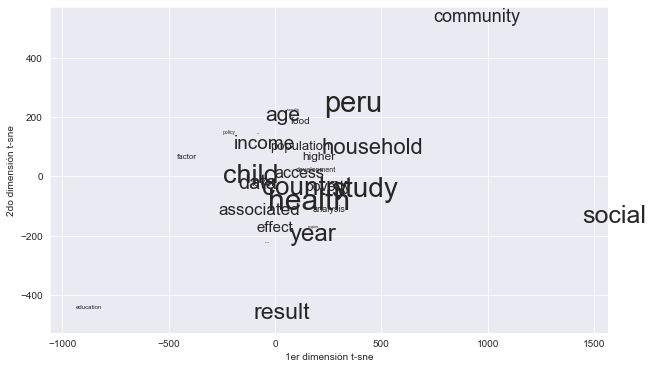

In [67]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(True)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  30 * (numWords - i) / numWords)
#plt.xticks(())
#plt.yticks(())
plt.xlabel("1er dimensión t-sne")
plt.ylabel("2do dimensión t-sne")
#plt.savefig('/Users/joseantoniomendozasanchez/abstract_analysis/tsne_general.png')
plt.show()